In [25]:
from self_supervised_halos.utils.utils import data_preprocess_path, check_cuda
from self_supervised_halos.scripts.halo_mass_embeddings import mask_time_series_batch, RegressionModel

from self_supervised_halos.utils.dataloader import HaloDataset, img2d_transform, subhalos_df, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
%matplotlib inline

device = check_cuda()

CUDA is not available.
Device: cpu


In [26]:
#dataset = HaloDataset(root_dir=data_preprocess_path,subhalos_df=subhalos_df, load_2d=False, load_3d=False, load_mass=True,)

In [27]:
if device=='cpu':
    batch_size = 128
else:
    print('dataloader on gpu')
    batch_size = 512

print(f'Batch size: {batch_size}')

n_data = len(dataset)
f_train = 0.6
f_val = 0.2
f_test = 1 - f_train - f_val


train_size = int(f_train*len(dataset))
val_size = int(f_val*len(dataset))
test_size = len(dataset) - train_size - val_size


trainval_ds, test_ds = torch.utils.data.random_split(dataset, [train_size+val_size, test_size])
train_size = int(f_train/(f_train+f_val)*len(trainval_ds))
val_size = len(trainval_ds) - train_size

train_ds, val_ds = torch.utils.data.random_split(trainval_ds, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)


Batch size: 128


In [28]:
lr = 1e-3
n_epochs=10


criterion = nn.MSELoss()

model = RegressionModel(
                    optimizer_class=torch.optim.Adam,
                    optimizer_params={'lr':lr},
                    scheduler_class=torch.optim.lr_scheduler.StepLR,
                    scheduler_params={'step_size':15, 'gamma':0.5},
                    criterion=criterion,
                    history=None,
                    transform=mask_time_series_batch,
)

model.load('Regression_1d.pth')


Model HaloMassHistTransformer not found at /Users/sdbykov/work/self_supervised_halos//results/models/Regression_1d.pth


In [29]:
model.trial_forward_pass(train_loader, device)

Trial Forward Pass limit_to_first_batch=True:   0%|          | 0/78 [00:00<?, ?it/s]

Loss: 1.4697216749191284
Trial forward pass elapsed time: 0.12 s (limit_to_first_batch=True)


Trial Forward Pass:   0%|          | 0/78 [00:00<?, ?it/s]

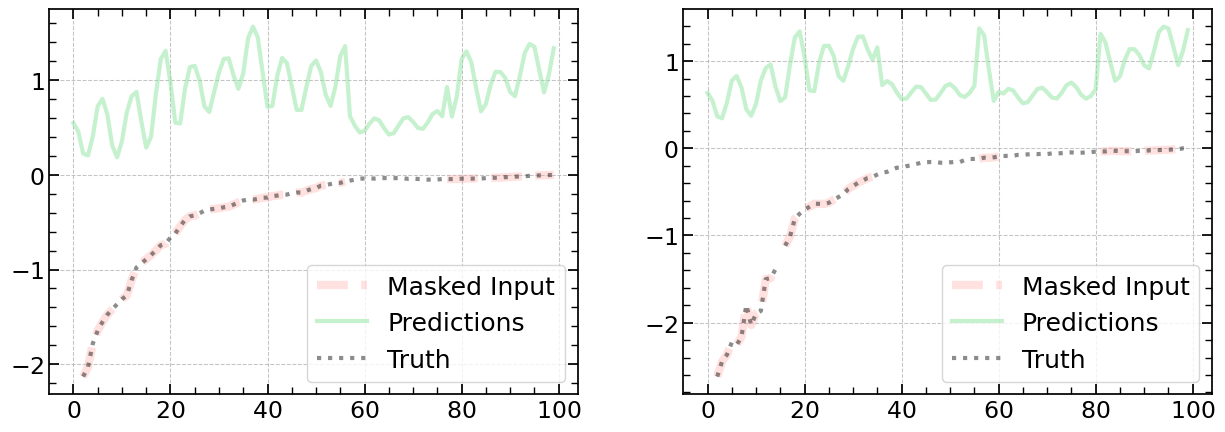

Trial Forward Pass:   0%|          | 0/78 [00:00<?, ?it/s]


In [30]:
model.show_transforms(train_loader, device)

In [31]:
model.training_loop(
    train_loader=train_loader, 
    val_loader=val_loader,
    num_epochs=n_epochs, 
    device=device)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Training Loss: 0.29819216502782625


Epochs:  10%|█         | 1/10 [00:27<04:07, 27.45s/it]

Epoch 1, Validation Loss: 0.20150245955357185
Epoch 2, Training Loss: 0.14982911199331284


Epochs:  20%|██        | 2/10 [00:51<03:22, 25.37s/it]

Epoch 2, Validation Loss: 0.07738044127248801
Epoch 3, Training Loss: 0.08351580201624295


Epochs:  30%|███       | 3/10 [01:20<03:08, 26.92s/it]

Epoch 3, Validation Loss: 0.06319503457500385
Epoch 4, Training Loss: 0.07068666481436828


Epochs:  40%|████      | 4/10 [01:52<02:53, 28.98s/it]

Epoch 4, Validation Loss: 0.05695011681662156
Epoch 5, Training Loss: 0.0650173031175748


Epochs:  50%|█████     | 5/10 [02:19<02:22, 28.50s/it]

Epoch 5, Validation Loss: 0.05624115008574266
Epoch 6, Training Loss: 0.06206453663225357


Epochs:  60%|██████    | 6/10 [02:46<01:51, 27.77s/it]

Epoch 6, Validation Loss: 0.05328859001971208
Epoch 7, Training Loss: 0.05762434989596025


Epochs:  70%|███████   | 7/10 [03:13<01:22, 27.44s/it]

Epoch 7, Validation Loss: 0.05260740550091633
Epoch 8, Training Loss: 0.057298509690624014


Epochs:  80%|████████  | 8/10 [03:40<00:55, 27.51s/it]

Epoch 8, Validation Loss: 0.04746275746191923
Epoch 9, Training Loss: 0.056333196659882866


Epochs:  90%|█████████ | 9/10 [04:05<00:26, 26.67s/it]

Epoch 9, Validation Loss: 0.04643072889974484
Epoch 10, Training Loss: 0.05384334126630655


Epochs: 100%|██████████| 10/10 [04:32<00:00, 27.22s/it]

Epoch 10, Validation Loss: 0.04568104488918415


In [32]:
model.save()

Model HaloMassHistTransformer saved at epoch 10


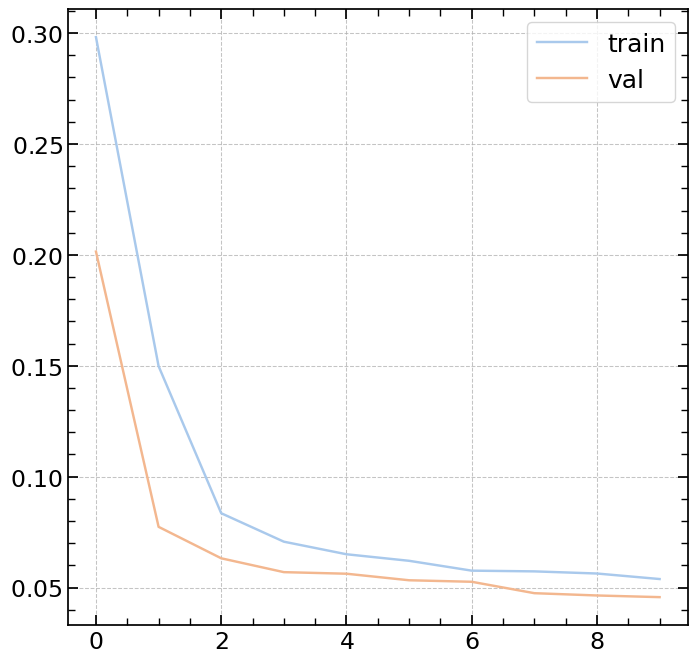

In [33]:
%matplotlib inline
plt.plot(model.history['train_loss'], label='train')
plt.plot(model.history['val_loss'], label='val')
plt.legend()
plt.show()

Trial Forward Pass:   0%|          | 0/26 [00:00<?, ?it/s]

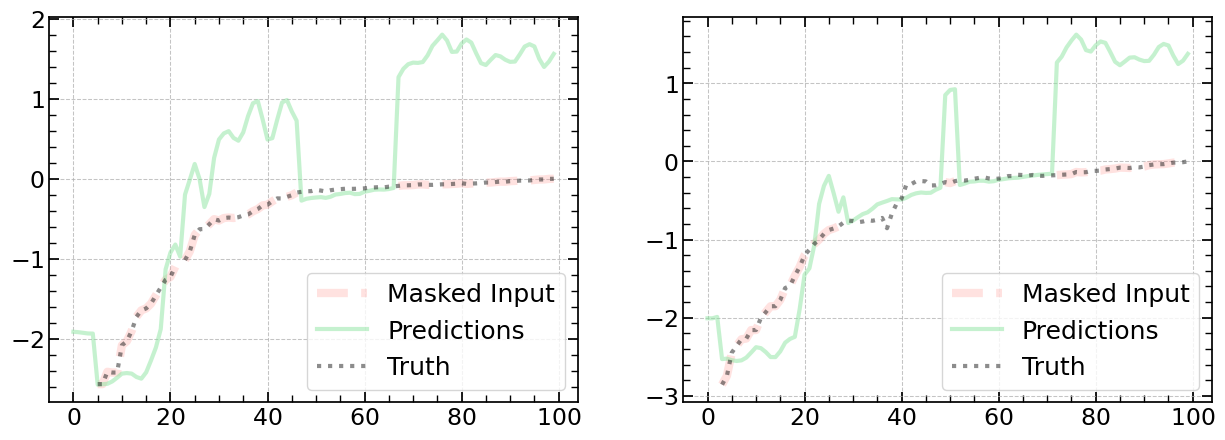

Trial Forward Pass:   0%|          | 0/26 [00:00<?, ?it/s]


In [34]:
model.show_transforms(test_loader, device)

Trial Forward Pass:   0%|          | 0/26 [00:00<?, ?it/s]

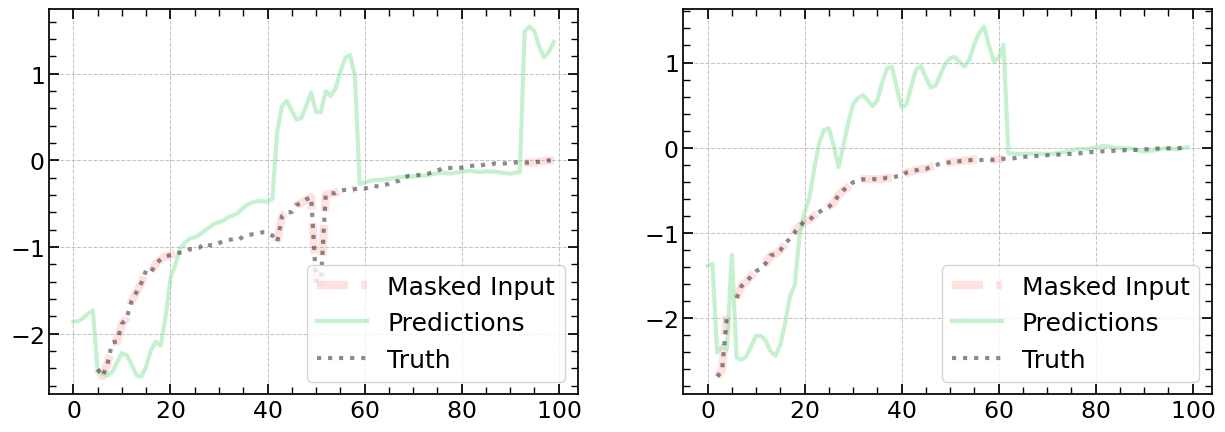

Trial Forward Pass:   0%|          | 0/26 [00:00<?, ?it/s]


In [35]:
model.show_transforms(test_loader, device)

----